# Titanic Survivor Detection

De dataset Titanic bevat de gegevens van de reizigers van Titanic. De dataset wordt geanalyseerd, voorbereid om het geschik te maken voor verder analyses. In this notebook zijn de alle stappen gedocumenteerd zodat het duidelijk is waarom bepaalde functies, en sub datasets gecreerd zijn. 

De notebook is verdeeld in verschillinde onderdelen, die gebasseerd zijn op de CRISP model die uit onderstaande fasen bestaat:
- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Deployement & Evaluation

De notebook is voornamelijk geschreven in het Nederlands, maar er komen toch wat Engels talige termen aangezien sommige termen duidelijker zijn in het Engels dan in het Nederlands. 


In [1]:
# Benodigde libraries/packages
import pandas as pd ## Data manipulation
import numpy as np ## Array processing
import matplotlib.pyplot as plt ## Visualization
import seaborn as sns ## Vizuaization


from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
%matplotlib inline

# ML libs. 
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv




# Data import/Business Understanding

In dit onderdeel zijn de onderstaande stappen doorgelopen:
1. Titanic dataset (test&training) importeren, en deze openen met Pandas dataframe
3. Maak een samenvatting van waarom het toepassen van ML op deze dataset belangrijk is. 

In [2]:
# Data import
traindf = pd.read_csv('data/titanic-training-dataset.csv')
testdf = pd.read_csv('data/titanic-test-dataset.csv')

traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
print('Total number of ROWS and COLUMNS in training data '+ str(traindf.shape))

Total number of ROWS and COLUMNS in training data (891, 12)


In [5]:
print('Total number of ROWS and COLUMNS in testing data '+ str(testdf.shape))

Total number of ROWS and COLUMNS in testing data (418, 11)


De dataset heeft 12 features:

1. PassengerId: ID van elke reiziger
2. Pclass: eerste, tweede of derde klas.
3. Name
4. Sex
5. Age
6. SibSp: aantal broer/zus & echtgenoot die niet op Titanic is
7. Parch: aantal ouders/kinderen die niet op Titanic is
8. Ticket: ticket nummer
9. Fare: ticketprijs
10. Cabin: Kamer nummer
11. Embarked: Q = Queenstown, S = Southampton, C = Cherbourg. Dit zijn de namen van de havens waar de passagier opgehaald is. 
12. **Survived**: dit is de target feature. 0 = overleden & 1 = survived

Blijkbaar is dezelfde opdracht beschikbaar ook in Kaggle. De bovenstaande informatie over de features zijn gebasseerd op de informatie uit Kaggle voor deze dataset.

**Business Understanding**

- Inzicht in waarom bepaalde mensen het ongeluk hebben overleefd.
- Data driven decision in de toekomst in een soortgelijke context



# Data Understanding

In dit onderdeel zijn alle features individueel geexploreerd. 

In [6]:
# Voordat we de features en rows manipuleren, is er merged table gemaakt van de initiele versie van traindf & testdf

mergeddf = traindf.append(testdf)

In [7]:
# PassengerID = table index
traindf.set_index(['PassengerId'], inplace=True) 
testdf.set_index(['PassengerId'], inplace=True)


## Ontbrekende waarde

In [8]:
traindf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [9]:
testdf.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

## Data types

Dataset heeft objecten, integers en floats. Vaak zijn de objecten catagorical features, echter het kan ook voorkomen dat integers ook catagorical zijn zoals het geval is bij **Pclass**

In [10]:
traindf.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Analyse van elke feature

In dit onderdeel wordt alle 12 feature individueel behandeld om inzicht te krijgen wat de waardes van elk feature betekennen.  

In [11]:
traindf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
traindf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Survival 
De kolom geeft weer of iemand het ongeluk heeft overleefd:

0 = not survived
1 = survived 

Total amount of travallers is: 891
Not survived: 62.0%
Survived: 38.0%


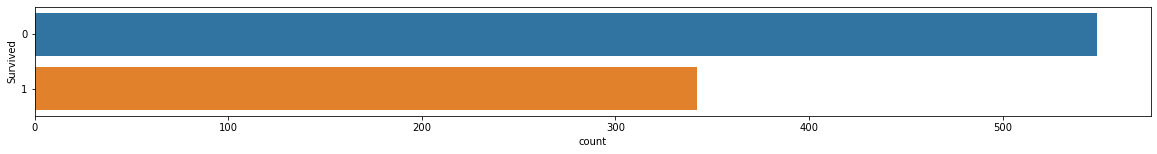

In [13]:
figure = plt.figure(figsize=(20,2))
sns.countplot(y= 'Survived', data=traindf)

counts = traindf.Survived.value_counts()

pernotser = (counts[0]/891)*100
perser = (counts[1]/891)*100
print('Total amount of travallers is: ' + str(len(traindf)))
print('Not survived: ' + str(pernotser.round()) + '%') # There should be an easier way of doing this..
print('Survived: ' + str(perser.round()) + '%')

Veel mensen (62% van 891 rows) zijn in Valhala, terwijl 32% van 891 mensen hebben het voor elkaar gekregen om in het leven te blijven. 

### Pclass
De kolom geeft de ticket klasse weer:
- 1 = Eerste klas
- 2 = Tweede klas
- 3 = Derde klas

1    216
2    184
3    491
Name: Pclass, dtype: int64

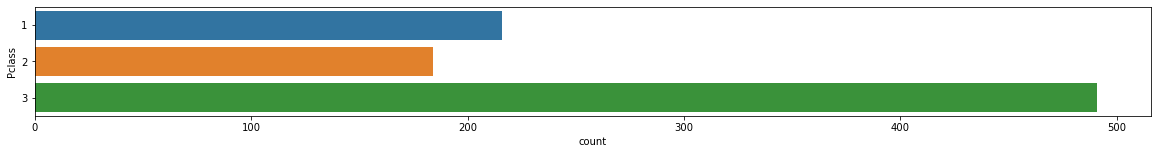

In [14]:
figure = plt.figure(figsize=(20,2))
sns.countplot(y= 'Pclass', data=traindf)

countp = traindf.Pclass.value_counts(ascending=True)
countp.sort_index()


Pclass is een integer maar wel een catagorical kolom (first class + second class != third class)

### Name

Namen zijn waarschijnelijk uniek. De kans is groot dat deze kolom niet gebruikt kan worden tijdens modeling. 


In [15]:
len(traindf.Name.value_counts())

891

De lengte van de output van Name.value_counts is 891. Dat betekent dat elk row een unieke waarde bevat. 

Deze kolom wordt verwijderd uit de model in de toekomst. 

(Om de accuracy score te verhoge kan er evt. meer feauters gecreerd worden van de Naam column: zoals Mr. Mrs en Miss)

### Sex

De gender van passagiers.

male      577
female    314
Name: Sex, dtype: int64

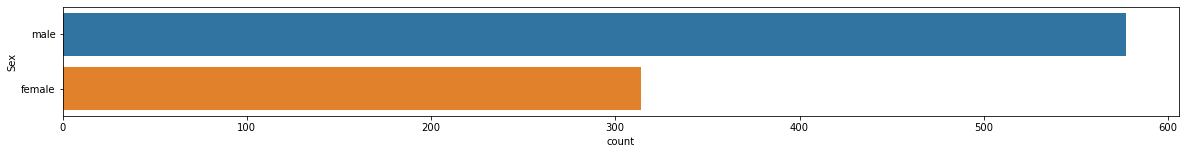

In [16]:
traindf.Sex.value_counts()

figure = plt.figure(figsize=(20,2))

sns.countplot(y = 'Sex', data=traindf)

traindf.Sex.value_counts()

In vergelijken waren er meer mannelijke passagiers dan vrouwelijke, 577 man en 314 vrouw. 

De data type van deze kolom is object, dus een catagorie. 

### Age

De leeftijd van passagiers


24.00    30
22.00    27
18.00    26
28.00    25
19.00    25
         ..
55.50     1
74.00     1
0.92      1
70.50     1
12.00     1
Name: Age, Length: 88, dtype: int64

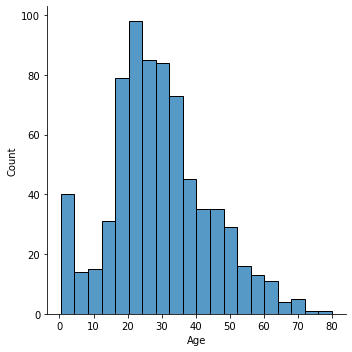

In [17]:
traindf.Age.value_counts()

sns.displot(traindf.Age)
traindf.Age.value_counts()

De ouput van Age.value_counts() is 88 in lengte, dat houdt in dat er 88 unieke waarden zijn in de kolom Age. De meeste passagiers zijn tussen de leeftijd 20 en 40. 

**ToDo**
- lable encoder for jong, volwassen en oud (miss meer zoals kind of baby, middle age, jong adult)

### SibSp

Aantal broer/zus/echtgenot van passagier buiten Titanic

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

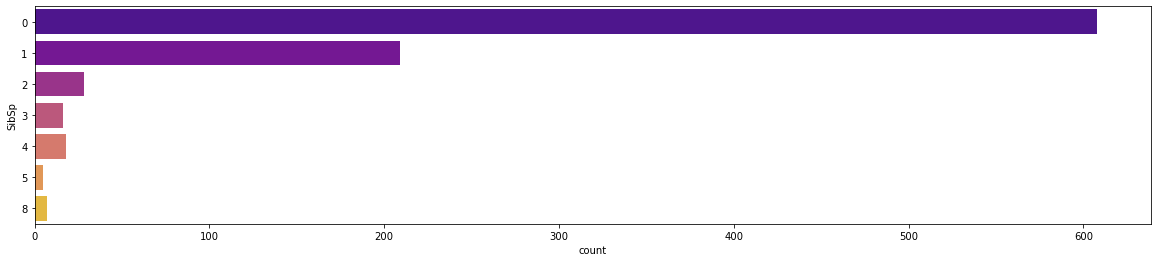

In [18]:
traindf.SibSp.value_counts()
figure = plt.figure(figsize=(20,4))

sns.countplot(y='SibSp', data=traindf, palette='plasma')

traindf.SibSp.value_counts()


Er zijn meer dan 600 passagiers die alleen zijn. 

### Parch

Aantal ouders/kinder die buiten Titanic zijn



0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

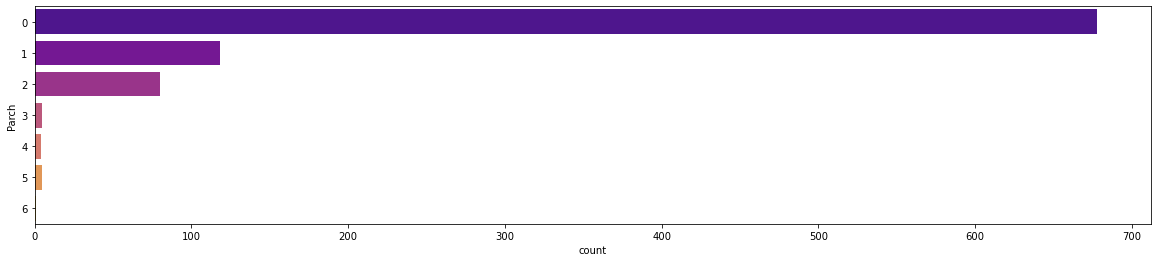

In [19]:
figure = plt.figure(figsize=(20,4))

sns.countplot(y='Parch', data=traindf, palette='plasma')

traindf.Parch.value_counts()

Bijna 700 reizigers een loner. 

**ToDo**
- Maak een nieuwe feature o.b.v. SibSp en Parch
- Label Encoder toepassen -> Alone, small, mid en big family. 

### Ticket

Kolom met ticket nummer

In [20]:
traindf.Ticket.describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [21]:
traindf.Ticket.head(10)

PassengerId
1            A/5 21171
2             PC 17599
3     STON/O2. 3101282
4               113803
5               373450
6               330877
7                17463
8               349909
9               347742
10              237736
Name: Ticket, dtype: object

Ticket kolom heeft 681 unieke waarden. Ticket nummer CA. 2343 komt 7 maal voor in de kolom. Dit is mogelijk veroorzaakt door meerder reizigers op 1 ticket...(Zoals kinderen en babies)

**ToDo**
- Deze kolom verwijderen uit de df

### Fare

Ticketprijs

In [22]:
traindf.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

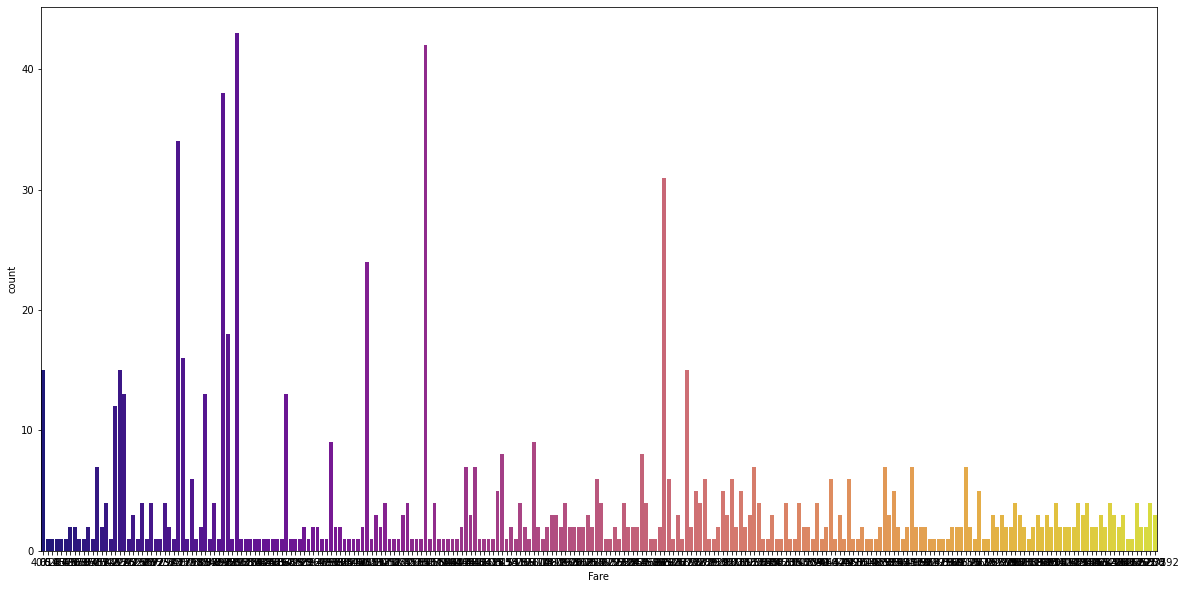

In [23]:
figure = plt.figure(figsize=(20,10))
sns.countplot(x=traindf.Fare, palette='plasma')

traindf.Fare.value_counts()

In [24]:
traindf.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

De kolom Fare heeft 248 unieke waarden en de waarden zijn erg verspreid. 

**ToDo**

- Maak hier een catagorie van: low, mid, high, expensive

### Cabin
 Cabin/kamer nummer. Deze kolom heeft er veel missende waarden.
 
**ToDo**
- Drop 

In [25]:
traindf.Cabin.isnull().sum()

687

### Embarked

Deze kolom bevat de namen van de haven waar passagiers opgehaald zijn:

- Q = Queenstown 
- S = Southampton 
- C = Cherbourg

In [26]:
traindf.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Embarked'>

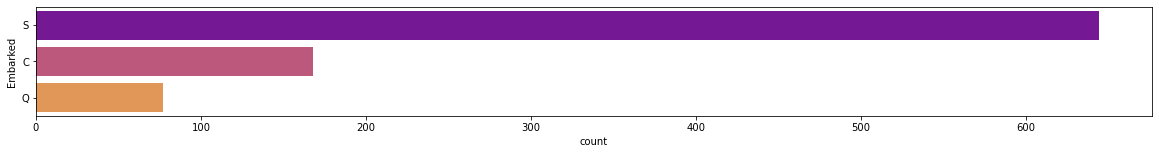

In [27]:
figure = plt.figure(figsize=(20,2))

sns.countplot(y='Embarked', data=traindf, palette='plasma')

644 passagiers zijn opgehaald van Southampton

## Data Preparation

In dit onderdeel wordt een schone dataframe voorbereid door onderstaande actie te onderneme:

- Onnodige kolommen verwijderen
- Missende waarden fixen
- Label encoder toepassen

In [28]:
# Kolommen Name, Cabin en Ticket worden verwijderd. 
traindf.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [29]:
traindf.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [30]:
# Function 4 missing values

def na_filler(data):
    
    data['Fare'] = data['Fare'].fillna(data['Fare'].dropna().median())
    data['Age'] = data['Age'].fillna(data['Age'].dropna().median())
    
    data['Embarked'] = data['Embarked'].fillna('S') # 'S' is de MOD. 

In [31]:
na_filler(traindf)

In [32]:
# Vanuit de traindf maken we nog 2 sub-dataset waarin catagorical features zijn apart opgeslagen dan de rest van de features. 

df_catagory = pd.DataFrame()
df_num = pd.DataFrame()

In [33]:
df_catagory['Survived'] = traindf['Survived']
df_num['Survived'] = traindf['Survived']

df_catagory['Pclass'] = traindf['Pclass']
df_num['Pclass'] = traindf['Pclass']

df_catagory['Sex'] = traindf['Sex']
df_num['Sex'] = traindf['Sex']
df_num['Sex'] = traindf.Sex.apply(lambda x:0 if x == 'male' else 1)

df_catagory['Age'] = traindf['Age']
df_num['Age'] = traindf['Age']

df_catagory['SibSp'] = traindf['SibSp']
df_num['SibSp'] = traindf['SibSp']

df_catagory['Parch'] = traindf['Parch']
df_num['Parch'] = traindf['Parch']

df_catagory['Fare'] = traindf['Fare']
df_num['Fare'] = pd.cut(traindf['Fare'], 5)

df_catagory['Embarked'] = traindf['Embarked']
df_num['Embarked'] = traindf['Embarked']









In [34]:
df_catagory.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [35]:
df_num.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,"(-0.512, 102.466]",S
2,1,1,1,38.0,1,0,"(-0.512, 102.466]",C
3,1,3,1,26.0,0,0,"(-0.512, 102.466]",S
4,1,1,1,35.0,1,0,"(-0.512, 102.466]",S
5,0,3,0,35.0,0,0,"(-0.512, 102.466]",S


In [36]:
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# Encoding

Er zijn 2 dataframes waarop ML toegepast wordt: df_catagory & df_num

In [37]:
df_catagory.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [38]:
### Encoded Catagory ####
df_catagory_encoded = df_catagory.apply(LabelEncoder().fit_transform)
df_catagory_encoded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,2,1,28,1,0,18,2
2,1,0,0,51,1,0,207,0
3,1,2,0,34,0,0,41,2
4,1,0,0,47,1,0,189,2
5,0,2,1,47,0,0,43,2


# Modeling

In [39]:
# df for data
x_train = df_catagory_encoded
x_train = x_train.drop('Survived', axis=1)

In [40]:
x_train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,2,1,28,1,0,18,2
2,0,0,51,1,0,207,0
3,2,0,34,0,0,41,2


In [41]:
# df for label

y_train = df_catagory_encoded.Survived

In [42]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [43]:
## Function: verschillende ml algoritme toepassen


def alg_scr(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [44]:
#LinReg
##Error: can not handle a mix of binary and continous target



In [45]:
# GBC
pred, accuracy_gbc, accuracy_crvl_gbc = alg_scr(GradientBoostingClassifier(), x_train, y_train, 10)

print('Accuracy: ' + str(accuracy_gbc) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_gbc) + '%')


Accuracy: 89.23%
Accuracy cross validation: 83.16%


In [46]:
# LogReg

pred, accuracy_LgR, accuracy_crvl_LgR = alg_scr(LogisticRegression(), x_train, y_train, 10)

print('Accuracy: ' + str(accuracy_LgR) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_LgR) + '%')


Accuracy: 79.91%
Accuracy cross validation: 79.12%


In [47]:
# DT
pred, accuracy_dt, accuracy_crvl_dt = alg_scr(DecisionTreeClassifier(), x_train, y_train, 10)

print('Accuracy: ' + str(accuracy_dt) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_dt) + '%')

Accuracy: 97.98%
Accuracy cross validation: 78.79%


In [48]:
# NB

pred, accuracy_nb, accuracy_crvl_nb = alg_scr(GaussianNB(), x_train, y_train, 10)

print('Accuracy: ' + str(accuracy_nb) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_nb) + '%')


Accuracy: 76.54%
Accuracy cross validation: 76.09%


In [49]:
# KNN

pred, accuracy_knn, accuracy_crvl_knn = alg_scr(KNeighborsClassifier(), x_train, y_train, 10)

print('Accuracy: ' + str(accuracy_knn) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_knn) + '%')



Accuracy: 79.01%
Accuracy cross validation: 69.7%


In [50]:
# SDG
pred, accuracy_sdg, accuracy_crvl_sdg = alg_scr(SGDClassifier(), x_train, y_train, 310)

print('Accuracy: ' + str(accuracy_sdg) + '%')
print('Accuracy cross validation: ' + str(accuracy_crvl_sdg) + '%')

Accuracy: 68.91%
Accuracy cross validation: 65.1%


In [51]:
# Catboos Calssifier

features = np.where(x_train.dtypes != np.float128)[0]
features

array([0, 1, 2, 3, 4, 5, 6])

In [52]:
# CatPool

pool = Pool(x_train, y_train, features)

In [53]:
# CatModel
cat_model = CatBoostClassifier(iterations=1000, custom_loss=['Accuracy'], loss_function='Logloss')

cat_model.fit(pool, plot=True)

cat_acc = round(cat_model.score(x_train, y_train)*100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.6876834	total: 55.3ms	remaining: 55.3s
1:	learn: 0.6819502	total: 64.4ms	remaining: 32.1s
2:	learn: 0.6769596	total: 66.6ms	remaining: 22.1s
3:	learn: 0.6717958	total: 69.7ms	remaining: 17.3s
4:	learn: 0.6662301	total: 75.1ms	remaining: 14.9s
5:	learn: 0.6612874	total: 80.3ms	remaining: 13.3s
6:	learn: 0.6558140	total: 84.9ms	remaining: 12s
7:	learn: 0.6510358	total: 92.1ms	remaining: 11.4s
8:	learn: 0.6460601	total: 97.2ms	remaining: 10.7s
9:	learn: 0.6415624	total: 102ms	remaining: 10.1s
10:	learn: 0.6368520	total: 107ms	remaining: 9.65s
11:	learn: 0.6320612	total: 112ms	remaining: 9.23s
12:	learn: 0.6278070	total: 116ms	remaining: 8.78s
13:	learn: 0.6235645	total: 118ms	remaining: 8.34s
14:	learn: 0.6192068	total: 121ms	remaining: 7.94s
15:	learn: 0.6152848	total: 123ms	remaining: 7.54s
16:	learn: 0.6117205	total: 126ms	remaining: 7.26s
17:	learn: 0.6076742	total: 128ms	remaining: 6.98s
18:	learn: 0.6034912	total: 131ms	remaining: 6.76s
19:	

169:	learn: 0.4164446	total: 573ms	remaining: 2.8s
170:	learn: 0.4162562	total: 576ms	remaining: 2.79s
171:	learn: 0.4161575	total: 576ms	remaining: 2.77s
172:	learn: 0.4155678	total: 579ms	remaining: 2.77s
173:	learn: 0.4152072	total: 582ms	remaining: 2.76s
174:	learn: 0.4145949	total: 586ms	remaining: 2.76s
175:	learn: 0.4142486	total: 588ms	remaining: 2.75s
176:	learn: 0.4136440	total: 591ms	remaining: 2.75s
177:	learn: 0.4131316	total: 594ms	remaining: 2.74s
178:	learn: 0.4126734	total: 596ms	remaining: 2.73s
179:	learn: 0.4121592	total: 600ms	remaining: 2.73s
180:	learn: 0.4113668	total: 603ms	remaining: 2.73s
181:	learn: 0.4110453	total: 605ms	remaining: 2.72s
182:	learn: 0.4106420	total: 608ms	remaining: 2.71s
183:	learn: 0.4104668	total: 611ms	remaining: 2.71s
184:	learn: 0.4097697	total: 614ms	remaining: 2.71s
185:	learn: 0.4095150	total: 617ms	remaining: 2.7s
186:	learn: 0.4094374	total: 618ms	remaining: 2.69s
187:	learn: 0.4087633	total: 621ms	remaining: 2.68s
188:	learn: 0.

354:	learn: 0.3645676	total: 1.16s	remaining: 2.1s
355:	learn: 0.3641603	total: 1.16s	remaining: 2.1s
356:	learn: 0.3640184	total: 1.17s	remaining: 2.1s
357:	learn: 0.3638721	total: 1.17s	remaining: 2.1s
358:	learn: 0.3634570	total: 1.17s	remaining: 2.1s
359:	learn: 0.3633175	total: 1.18s	remaining: 2.09s
360:	learn: 0.3629583	total: 1.18s	remaining: 2.09s
361:	learn: 0.3627561	total: 1.18s	remaining: 2.09s
362:	learn: 0.3624722	total: 1.19s	remaining: 2.08s
363:	learn: 0.3621964	total: 1.19s	remaining: 2.08s
364:	learn: 0.3620022	total: 1.19s	remaining: 2.07s
365:	learn: 0.3618295	total: 1.19s	remaining: 2.07s
366:	learn: 0.3617998	total: 1.2s	remaining: 2.06s
367:	learn: 0.3617899	total: 1.2s	remaining: 2.06s
368:	learn: 0.3616632	total: 1.2s	remaining: 2.05s
369:	learn: 0.3615623	total: 1.2s	remaining: 2.05s
370:	learn: 0.3614194	total: 1.21s	remaining: 2.04s
371:	learn: 0.3614128	total: 1.21s	remaining: 2.04s
372:	learn: 0.3613100	total: 1.21s	remaining: 2.04s
373:	learn: 0.3611670

554:	learn: 0.3333160	total: 1.73s	remaining: 1.39s
555:	learn: 0.3331036	total: 1.73s	remaining: 1.38s
556:	learn: 0.3329630	total: 1.73s	remaining: 1.38s
557:	learn: 0.3328515	total: 1.74s	remaining: 1.38s
558:	learn: 0.3327595	total: 1.74s	remaining: 1.37s
559:	learn: 0.3325986	total: 1.74s	remaining: 1.37s
560:	learn: 0.3323958	total: 1.75s	remaining: 1.36s
561:	learn: 0.3323142	total: 1.75s	remaining: 1.36s
562:	learn: 0.3322578	total: 1.75s	remaining: 1.36s
563:	learn: 0.3321741	total: 1.75s	remaining: 1.35s
564:	learn: 0.3318860	total: 1.76s	remaining: 1.35s
565:	learn: 0.3317927	total: 1.76s	remaining: 1.35s
566:	learn: 0.3314783	total: 1.76s	remaining: 1.34s
567:	learn: 0.3313927	total: 1.76s	remaining: 1.34s
568:	learn: 0.3313228	total: 1.76s	remaining: 1.34s
569:	learn: 0.3313211	total: 1.77s	remaining: 1.33s
570:	learn: 0.3313104	total: 1.77s	remaining: 1.33s
571:	learn: 0.3312979	total: 1.77s	remaining: 1.32s
572:	learn: 0.3310920	total: 1.77s	remaining: 1.32s
573:	learn: 

770:	learn: 0.3058517	total: 2.3s	remaining: 683ms
771:	learn: 0.3057038	total: 2.3s	remaining: 680ms
772:	learn: 0.3054846	total: 2.3s	remaining: 677ms
773:	learn: 0.3052755	total: 2.31s	remaining: 674ms
774:	learn: 0.3050097	total: 2.31s	remaining: 671ms
775:	learn: 0.3049149	total: 2.31s	remaining: 668ms
776:	learn: 0.3048422	total: 2.31s	remaining: 665ms
777:	learn: 0.3047768	total: 2.32s	remaining: 661ms
778:	learn: 0.3047137	total: 2.32s	remaining: 658ms
779:	learn: 0.3046185	total: 2.32s	remaining: 655ms
780:	learn: 0.3043279	total: 2.32s	remaining: 652ms
781:	learn: 0.3041998	total: 2.33s	remaining: 649ms
782:	learn: 0.3041391	total: 2.33s	remaining: 646ms
783:	learn: 0.3040989	total: 2.33s	remaining: 643ms
784:	learn: 0.3039294	total: 2.33s	remaining: 639ms
785:	learn: 0.3038934	total: 2.34s	remaining: 636ms
786:	learn: 0.3036938	total: 2.34s	remaining: 633ms
787:	learn: 0.3036505	total: 2.35s	remaining: 631ms
788:	learn: 0.3033803	total: 2.35s	remaining: 628ms
789:	learn: 0.3

988:	learn: 0.2808322	total: 2.88s	remaining: 32ms
989:	learn: 0.2805786	total: 2.88s	remaining: 29.1ms
990:	learn: 0.2805292	total: 2.88s	remaining: 26.2ms
991:	learn: 0.2803723	total: 2.89s	remaining: 23.3ms
992:	learn: 0.2803288	total: 2.89s	remaining: 20.4ms
993:	learn: 0.2802959	total: 2.89s	remaining: 17.5ms
994:	learn: 0.2800908	total: 2.9s	remaining: 14.5ms
995:	learn: 0.2800330	total: 2.9s	remaining: 11.6ms
996:	learn: 0.2799545	total: 2.9s	remaining: 8.74ms
997:	learn: 0.2798914	total: 2.91s	remaining: 5.83ms
998:	learn: 0.2798185	total: 2.91s	remaining: 2.91ms
999:	learn: 0.2798032	total: 2.91s	remaining: 0us


In [54]:
# CatBoost Cross Validation
crvl_param = cat_model.get_params()

crvl_data = cv(pool, crvl_param, fold_count=10, plot=True)

accuracy_crvl_cb = round(np.max(crvl_data['test-Accuracy-mean'])*100,2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6747513	test: 0.6749059	best: 0.6749059 (0)
1:	learn: 0.6590152	test: 0.6594347	best: 0.6594347 (1)
2:	learn: 0.6442085	test: 0.6453058	best: 0.6453058 (2)
3:	learn: 0.6301139	test: 0.6319241	best: 0.6319241 (3)
4:	learn: 0.6172756	test: 0.6193308	best: 0.6193308 (4)
5:	learn: 0.6061364	test: 0.6083850	best: 0.6083850 (5)
6:	learn: 0.5957178	test: 0.5980664	best: 0.5980664 (6)
7:	learn: 0.5844414	test: 0.5874913	best: 0.5874913 (7)
8:	learn: 0.5744093	test: 0.5775768	best: 0.5775768 (8)
9:	learn: 0.5652394	test: 0.5690511	best: 0.5690511 (9)
10:	learn: 0.5566268	test: 0.5608926	best: 0.5608926 (10)
11:	learn: 0.5483604	test: 0.5531512	best: 0.5531512 (11)
12:	learn: 0.5409436	test: 0.5460970	best: 0.5460970 (12)
13:	learn: 0.5339521	test: 0.5396333	best: 0.5396333 (13)
14:	learn: 0.5280925	test: 0.5343952	best: 0.5343952 (14)
15:	learn: 0.5221652	test: 0.5292864	best: 0.5292864 (15)
16:	learn: 0.5173524	test: 0.5247136	best: 0.5247136 (16)
17:	learn: 0.5120001	test: 0.51959

230:	learn: 0.3122711	test: 0.4262129	best: 0.4247153 (206)
231:	learn: 0.3118103	test: 0.4261762	best: 0.4247153 (206)
232:	learn: 0.3114414	test: 0.4262565	best: 0.4247153 (206)
233:	learn: 0.3110756	test: 0.4262807	best: 0.4247153 (206)
234:	learn: 0.3107357	test: 0.4263572	best: 0.4247153 (206)
235:	learn: 0.3104193	test: 0.4264752	best: 0.4247153 (206)
236:	learn: 0.3100611	test: 0.4264651	best: 0.4247153 (206)
237:	learn: 0.3097241	test: 0.4263640	best: 0.4247153 (206)
238:	learn: 0.3093994	test: 0.4262959	best: 0.4247153 (206)
239:	learn: 0.3090090	test: 0.4262956	best: 0.4247153 (206)
240:	learn: 0.3085989	test: 0.4262009	best: 0.4247153 (206)
241:	learn: 0.3083889	test: 0.4262026	best: 0.4247153 (206)
242:	learn: 0.3080303	test: 0.4263256	best: 0.4247153 (206)
243:	learn: 0.3078050	test: 0.4263223	best: 0.4247153 (206)
244:	learn: 0.3075173	test: 0.4262681	best: 0.4247153 (206)
245:	learn: 0.3071349	test: 0.4265063	best: 0.4247153 (206)
246:	learn: 0.3067948	test: 0.4266404	be

466:	learn: 0.2387474	test: 0.4312523	best: 0.4247153 (206)
467:	learn: 0.2384491	test: 0.4314035	best: 0.4247153 (206)
468:	learn: 0.2382562	test: 0.4312064	best: 0.4247153 (206)
469:	learn: 0.2380365	test: 0.4313623	best: 0.4247153 (206)
470:	learn: 0.2376983	test: 0.4313915	best: 0.4247153 (206)
471:	learn: 0.2373624	test: 0.4316805	best: 0.4247153 (206)
472:	learn: 0.2371112	test: 0.4317727	best: 0.4247153 (206)
473:	learn: 0.2368224	test: 0.4317532	best: 0.4247153 (206)
474:	learn: 0.2365203	test: 0.4316245	best: 0.4247153 (206)
475:	learn: 0.2362642	test: 0.4318821	best: 0.4247153 (206)
476:	learn: 0.2360270	test: 0.4319140	best: 0.4247153 (206)
477:	learn: 0.2356172	test: 0.4317558	best: 0.4247153 (206)
478:	learn: 0.2352933	test: 0.4315084	best: 0.4247153 (206)
479:	learn: 0.2350907	test: 0.4315599	best: 0.4247153 (206)
480:	learn: 0.2347201	test: 0.4316516	best: 0.4247153 (206)
481:	learn: 0.2344442	test: 0.4317869	best: 0.4247153 (206)
482:	learn: 0.2341833	test: 0.4316573	be

635:	learn: 0.1990890	test: 0.4388011	best: 0.4247153 (206)
636:	learn: 0.1988935	test: 0.4389291	best: 0.4247153 (206)
637:	learn: 0.1986605	test: 0.4390447	best: 0.4247153 (206)
638:	learn: 0.1984394	test: 0.4391590	best: 0.4247153 (206)
639:	learn: 0.1982727	test: 0.4390709	best: 0.4247153 (206)
640:	learn: 0.1980845	test: 0.4391291	best: 0.4247153 (206)
641:	learn: 0.1978812	test: 0.4392367	best: 0.4247153 (206)
642:	learn: 0.1977077	test: 0.4391725	best: 0.4247153 (206)
643:	learn: 0.1975346	test: 0.4394284	best: 0.4247153 (206)
644:	learn: 0.1974160	test: 0.4395065	best: 0.4247153 (206)
645:	learn: 0.1972082	test: 0.4395160	best: 0.4247153 (206)
646:	learn: 0.1969836	test: 0.4397642	best: 0.4247153 (206)
647:	learn: 0.1968370	test: 0.4397150	best: 0.4247153 (206)
648:	learn: 0.1966910	test: 0.4397269	best: 0.4247153 (206)
649:	learn: 0.1964479	test: 0.4397168	best: 0.4247153 (206)
650:	learn: 0.1962885	test: 0.4395986	best: 0.4247153 (206)
651:	learn: 0.1960730	test: 0.4396269	be

804:	learn: 0.1692288	test: 0.4463511	best: 0.4247153 (206)
805:	learn: 0.1690731	test: 0.4463350	best: 0.4247153 (206)
806:	learn: 0.1689320	test: 0.4463293	best: 0.4247153 (206)
807:	learn: 0.1687827	test: 0.4463555	best: 0.4247153 (206)
808:	learn: 0.1686537	test: 0.4463457	best: 0.4247153 (206)
809:	learn: 0.1684789	test: 0.4464465	best: 0.4247153 (206)
810:	learn: 0.1683222	test: 0.4465416	best: 0.4247153 (206)
811:	learn: 0.1681719	test: 0.4465246	best: 0.4247153 (206)
812:	learn: 0.1680040	test: 0.4467852	best: 0.4247153 (206)
813:	learn: 0.1678684	test: 0.4468341	best: 0.4247153 (206)
814:	learn: 0.1677768	test: 0.4469561	best: 0.4247153 (206)
815:	learn: 0.1676587	test: 0.4468615	best: 0.4247153 (206)
816:	learn: 0.1675342	test: 0.4468843	best: 0.4247153 (206)
817:	learn: 0.1673405	test: 0.4469968	best: 0.4247153 (206)
818:	learn: 0.1671979	test: 0.4470067	best: 0.4247153 (206)
819:	learn: 0.1671037	test: 0.4470689	best: 0.4247153 (206)
820:	learn: 0.1669446	test: 0.4472064	be

981:	learn: 0.1450393	test: 0.4561067	best: 0.4247153 (206)
982:	learn: 0.1449370	test: 0.4561207	best: 0.4247153 (206)
983:	learn: 0.1448034	test: 0.4561825	best: 0.4247153 (206)
984:	learn: 0.1447382	test: 0.4560693	best: 0.4247153 (206)
985:	learn: 0.1446130	test: 0.4561068	best: 0.4247153 (206)
986:	learn: 0.1445114	test: 0.4561541	best: 0.4247153 (206)
987:	learn: 0.1443759	test: 0.4562030	best: 0.4247153 (206)
988:	learn: 0.1442506	test: 0.4561452	best: 0.4247153 (206)
989:	learn: 0.1440632	test: 0.4563752	best: 0.4247153 (206)
990:	learn: 0.1439630	test: 0.4564230	best: 0.4247153 (206)
991:	learn: 0.1438462	test: 0.4565080	best: 0.4247153 (206)
992:	learn: 0.1437324	test: 0.4564655	best: 0.4247153 (206)
993:	learn: 0.1435766	test: 0.4565689	best: 0.4247153 (206)
994:	learn: 0.1434104	test: 0.4566519	best: 0.4247153 (206)
995:	learn: 0.1432948	test: 0.4568732	best: 0.4247153 (206)
996:	learn: 0.1431574	test: 0.4570612	best: 0.4247153 (206)
997:	learn: 0.1430612	test: 0.4570976	be

In [55]:
cat_acc

89.0

In [56]:
accuracy_crvl_cb

81.26

In [57]:
# Table: all ML algs

table = pd.DataFrame({
    'Model': ['KNeighborsClassifier', 'GradientBoostingClassifier', 'LogisticRegression', 
              'DecisionTreeClassifier', 'GaussianNB', 'SDGClassifier', 'CatBoost'],
    
    'Regular Accuracy %': [accuracy_knn, accuracy_gbc, accuracy_LgR, accuracy_dt, accuracy_nb, accuracy_sdg, cat_acc],
    
    
    'CV Accuracy %': [accuracy_crvl_knn, accuracy_crvl_gbc, 
                      accuracy_crvl_LgR, accuracy_crvl_dt, accuracy_crvl_nb,accuracy_crvl_sdg, accuracy_crvl_cb]})

table.sort_values(by = 'CV Accuracy %', ascending=False)

,Model,Regular Accuracy %,CV Accuracy %
1,GradientBoostingClassifier,89.23,83.16
6,CatBoost,89.00,81.26
2,LogisticRegression,79.91,79.12
3,DecisionTreeClassifier,97.98,78.79
4,GaussianNB,76.54,76.09
0,KNeighborsClassifier,79.01,69.70
5,SDGClassifier,68.91,65.10


In [59]:
model = GradientBoostingClassifier()

model.fit(x_train, y_train)

GradientBoostingClassifier()

In [60]:
acc = model.score(x_train, y_train)
acc

0.8922558922558923

In [ ]:
def alg_scr(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [66]:
cv = 10
cval = model_selection.cross_val_predict(GradientBoostingClassifier(), x_train, y_train, cv=cv, n_jobs=-1)
cval

acc_cval = metrics.accuracy_score(y_train, cval)
acc_cval

0.8316498316498316

# Unsaved Version with lot of features.

In [155]:
# Function 4 missing values

def nafiller(data):
    
    data['Fare'] = data['Fare'].fillna(data['Fare'].dropna().median())
    data['Age'] = data['Age'].fillna(data['Age'].dropna().median())
    
    data['Embarked'] = data['Emb
                            arked'].fillna('S') # 'S' is the mod of this column. 


In [13]:
traindf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
nafiller(traindf)
nafiller(testdf)

In [15]:
traindf.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

In [16]:
traindf.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [17]:
testdf.isnull().sum()

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       327
Embarked      0
dtype: int64

In [18]:
testdf.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [19]:
# Cabin columns has too many missing values. So it will be dropped

traindf.drop('Cabin', axis=1, inplace=True)
testdf.drop('Cabin', axis=1, inplace=True)

In [20]:
traindf.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [21]:
testdf.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

In [22]:
traindf.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [23]:
testdf.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [24]:
traindf.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
testdf.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.599282,0.447368,0.392344,35.576535
std,0.841838,12.703770,0.896760,0.981429,55.850103
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,35.750000,1.000000,0.000000,31.471875
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [26]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S


In [27]:
traindf['Sex'] = traindf.Sex.apply(lambda x:0 if x == 'male' else 1)

In [28]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,S


In [29]:
# De data frame is bijna schoon, nog een stap is het verwijderen van de Outliers

sns.boxplot(x='Survived', y='Fare', data=traindf)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

In [30]:
traindf['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

In [31]:
##################################Statistics#######################################

In [32]:
traindf.groupby('Sex').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,
0,0.188908,2.389948,30.140676,0.429809,0.235702,25.523893
1,0.742038,2.159236,27.929936,0.694268,0.649682,44.479818


In [33]:
traindf.groupby('Survived').mean()

,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,,,,,,
0,2.531876,0.147541,30.028233,0.553734,0.329690,22.117887
1,1.950292,0.681287,28.291433,0.473684,0.464912,48.395408


In [34]:
traindf.groupby('Pclass').mean()

,Survived,Sex,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,0.629630,0.435185,36.812130,0.416667,0.356481,84.154687
2,0.472826,0.413043,29.765380,0.402174,0.380435,20.662183
3,0.242363,0.293279,25.932627,0.615071,0.393075,13.675550


In [35]:
traindf.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.064910,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.339898,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.081163,0.114631,0.245489,0.182333
Age,-0.064910,-0.339898,-0.081163,1.000000,-0.233296,-0.172482,0.096688
SibSp,-0.035322,0.083081,0.114631,-0.233296,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.172482,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.096688,0.159651,0.216225,1.000000


In [36]:
#Heatmap

plt.subplots(figsize = (15,8))
sns.heatmap(traindf.corr(), annot=True, cmap='PiYG')

<AxesSubplot:>

In [37]:
sns.barplot(x='Sex', y='Survived', data=traindf)

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

In [38]:
sns.barplot(x='Pclass', y='Survived', data=traindf)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

In [39]:
sns.kdeplot(traindf.loc[(traindf['Survived']==0), 'Age'],color='orange', shade=True, Label='Dead')
sns.kdeplot(traindf.loc[(traindf['Survived']==1), 'Age'],color='black', shade=True, Label='Survived')

/home/ds/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/home/ds/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/home/ds/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/home/ds/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

In [40]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,S


In [41]:
## Adding some features

traindf['FamilySize'] = traindf['SibSp']+traindf['Parch']+1 # No 0 values are allowed
traindf.FamilySize.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [42]:
def familyGroup(size):
    
    grouping = ''
    
    if size == 0:
        grouping = 'Alone'
    elif size <=4:
        grouping = 'Small'
    else:
        grouping = 'Big'
        
    return grouping

In [43]:
traindf['familygroup'] = traindf.FamilySize.map(familyGroup)

In [44]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,familygroup
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,2,Small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,2,Small
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Small
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,2,Small
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,1,Small
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S,1,Small
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S,1,Small
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,S,4,Small


In [45]:
def groupingAge(age):
    grouping = ''
    
    if age<=1:
        grouping = 'Baby'
    elif age <= 4:
        grouping = 'Kid'
    elif age <= 18:
        grouping = 'Teen'
    elif age <=25:
        grouping='Young Adult'
    elif age <= 45:
        grouping = 'Adult'
    elif age <= 59:
        grouping = 'Middle Age'
    else:
        grouping = 'Elder'
    return grouping

In [46]:
traindf['AgeGroup'] = traindf.Age.map(groupingAge)

In [47]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,familygroup,AgeGroup
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,2,Small,Young Adult
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,2,Small,Adult
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Small,Adult
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,2,Small,Adult
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,1,Small,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S,1,Small,Adult
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S,1,Small,Young Adult
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,S,4,Small,Adult


In [48]:
def fareGrouping(fare):
    
    grouping = ''
    if fare <= 10:
        grouping = 'Low'
    elif fare <=25:
        grouping = 'Mid'
    elif fare <= 45:
        grouping = 'High'
    else:
        grouping = 'Extra High'
    return grouping

In [49]:
traindf['FareGrouping'] = traindf.Fare.map(fareGrouping)

In [50]:
traindf

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,familygroup,AgeGroup,FareGrouping
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,2,Small,Young Adult,Low
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,2,Small,Adult,Extra High
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Small,Adult,Low
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,2,Small,Adult,Extra High
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,1,Small,Adult,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S,1,Small,Adult,Mid
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S,1,Small,Young Adult,High
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,S,4,Small,Adult,Mid


In [51]:
traindf = pd.get_dummies(traindf, columns=['Embarked', 'familygroup', 'AgeGroup', 'FareGrouping'], drop_first= True)

In [53]:
traindf.shape

(891, 22)

In [55]:
traindf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,...,familygroup_Small,AgeGroup_Baby,AgeGroup_Elder,AgeGroup_Kid,AgeGroup_Middle Age,AgeGroup_Teen,AgeGroup_Young Adult,FareGrouping_High,FareGrouping_Low,FareGrouping_Mid
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2,...,1,0,0,0,0,0,1,0,1,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,2,...,1,0,0,0,0,0,0,0,0,0
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,1,...,1,0,0,0,0,0,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2,...,1,0,0,0,0,0,0,0,0,0
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1,...,1,0,0,0,0,0,0,0,1,0
